In [1]:
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import requests

from skimage.measure import label, regionprops
from skimage.draw import rectangle_perimeter

from pyproj import Proj

In [2]:
API_URL = "https://try_to_deploy_your_own_model_at_.herokuapps.com/its_really_simple"

project_path = "./"
orto_path = project_path + "data/geoportal_orto/"
mask_path = project_path + "data/geoportal_build_mask/"

ids = os.listdir(orto_path)

In [3]:
def open_image(path):
    return plt.imread(path)[:, :, :3]

def open_mask(path):
    img_mask = plt.imread(path)[:, :, 0]
    return (img_mask > img_mask.min()).astype(int)

def get_prediction(img_data, pred_thresh=0.5, url=API_URL):
    data = {'arr': img_data.tolist()}
    response = requests.post(url, json=data)
    mask_pred = response.json().get("mask_pred")

    return np.array(mask_pred) > pred_thresh

def plot_images(images_to_plot):

    plot_height = 6
    fig, ax = plt.subplots(1, len(images_to_plot), figsize=(plot_height*len(images_to_plot), plot_height))
    for idx, image in enumerate(images_to_plot):
        ax[idx].imshow(image)

def coords_to_latlon(x, y, projection='epsg:2180'):
    converter = Proj(projection)
    return converter(x, y, inverse=True)

In [4]:
def compare_build_masks(img, mask, mask_pred, img_min_coords = (0, 0), min_compared_area = 1, match_thresh = 0.5):

    # minimal ratio of (predicted_mask - true_mask)/predicted_mask
    region_match_thresh = match_thresh

    compare_results = {
        "img": img,
        "mask": mask,
        "mask_pred": mask_pred,
        "img_coords": img_min_coords,
        "dicrepacy_coords": []
    }

    # grab labeled regions measurements
    regions_pred = regionprops(label(compare_results["mask_pred"]).squeeze())

    for region in regions_pred:

        # take regions with large enough areas
        if region.area >= min_compared_area:

            # get coordinates of rectangle around region
            minr, minc, maxr, maxc = region.bbox

            # sum non-empty values from masks
            build_sum = compare_results["mask"][minr:maxr, minc:maxc].sum()
            build_sum_pred = compare_results["mask_pred"][minr:maxr, minc:maxc].sum()

            # comparing masks
            if_masks_diff = build_sum_pred - build_sum > region_match_thresh * build_sum_pred

            # leaving two colors for now, as we'd like to know all found masks
            # colors values in rgb/255
            region_match_rgb = (1, 0, 0) if if_masks_diff else (0, 1, 0)

            # draw rectangle
            rect_r, rect_c = rectangle_perimeter((minr, minc), (maxr, maxc), shape=img.shape, clip=True)
            compare_results["img"][rect_r, rect_c, :] = region_match_rgb

            if if_masks_diff:

                # grab region centroid and build coords for it
                centr_r, centr_c = region.centroid
                dicrepacy_x, dicrepacy_y = img_min_coords[0] + centr_r, img_min_coords[1] + centr_c
                compare_results["dicrepacy_coords"].append((dicrepacy_x, dicrepacy_y))

    return compare_results

In [5]:
i = 6767
img_file_name = ids[i]
img = open_image(orto_path + img_file_name)

img_min_coords = 552012, 825179 # sure we'll use some fake coords - it's just an example, duh
img_latlon = tuple(reversed(coords_to_latlon(*img_min_coords)))

mask = open_mask(mask_path + img_file_name)
mask_pred = get_prediction(img, pred_thresh=0.5)

print("image shape:", img.shape)
print("true_mask shape:", mask.shape)
print("pred_mask shape:", mask_pred.shape)

image shape: (256, 256, 3)
true_mask shape: (256, 256)
pred_mask shape: (256, 256, 1)


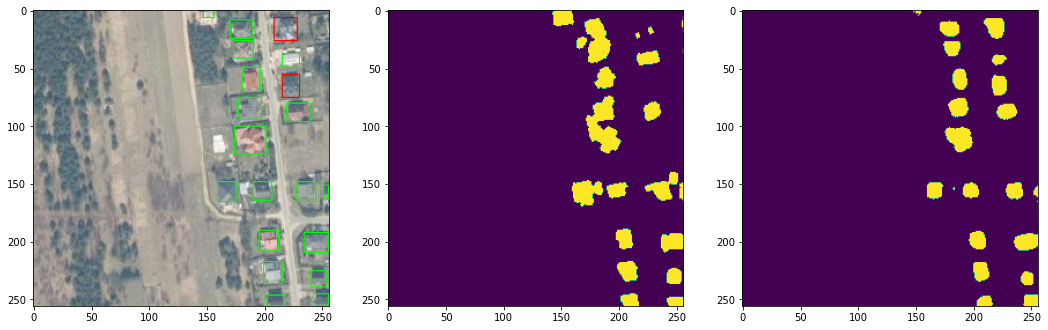

In [6]:
results_dict = compare_build_masks(
    img,
    mask,
    mask_pred,
    img_min_coords = img_min_coords,
    min_compared_area = 10, # assuming 10 square meters as min. building size
    match_thresh = 0.5 # finding with more than 50% over officially registered
)

plot_images((results_dict["img"], results_dict["mask"], results_dict["mask_pred"]))

In [7]:
print("---\nimg_latlon")
pprint(img_latlon)

print("---\ndicrepacy_coords")
pprint([
    tuple(reversed(coords_to_latlon(x, y)))
    for x, y in results_dict["dicrepacy_coords"]
])

---
img_latlon
(55.286845836888666, 19.81919566137259)
---
dicrepacy_coords
[(55.28880887756785, 19.81946243676782),
 (55.28883371132401, 19.820254246839568)]
